In [1]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv


import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from scipy.optimize import minimize_scalar

from poly_basis import *

from ex2_helper import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [246]:
def rbf(r):
    return np.exp(-eps * r**2)
def rbfd_div_r(r):
    return -2*eps*rbf(r)
def rbfd2(r):
    return 2*eps*rbf(r)*(2*eps*r**2-1)

def rbfL(r):
    return rbfd2(r) + rbfd_div_r(r) *2

def grad_rbf(node, center):
    r = dist(node, center)
    return rbfd_div_r(r) * (node - center)


def foo1(node):
    return -2*node[0]
def exact1(node):
    return node[0]

# l=2
def foo2(node):
    return -6 * (node[0]**2 - node[1]**2)
def exact2(node):
    return (node[0]**2 - node[1]**2)

# l=3
def foo3(node):
    return -(node[0]**2 - node[1]**2) * node[2] * 12

def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]

# l=4
def foo4(node):
    return -(3*node[0]**2 - node[1]**2)*node[1]*node[2] * 20
def exact4(node):
    return (3*node[0]**2 - node[1]**2)*node[1]*node[2]

In [298]:
n = 100
k = n
delta = .2
gamma = .2
my_node = n//4
eps = 2

foo, exact = foo1, exact1

cond A: 5.24652e+11
cond B: 5.24652e+11
0.01115744466737452
-0.0118240876383646


<IPython.core.display.Javascript object>


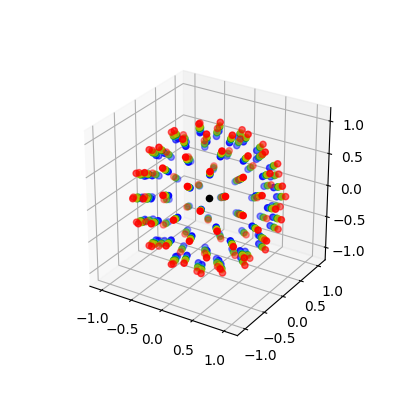

In [299]:
nodes = gen_spiral_nodes(n)
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[my_node], k)[1]
nn = np.array([nodes[i] for i in stencil]) #nodes in the stencil

# calculate smallest distance between nodes
dist_mat = [[dist(x,y) for x in nn] for y in nn]
d = np.min(np.diag([10**5]*k) + dist_mat)*delta

# form X^+ and X^-
nnp = nn*(1+d)
nnm = nn*(1-d)
# is the array containing all the X, followed by X^+, followed by X^-
nna = np.block([[nn],[nnp],[nnm]])

# reconstruct surface as the zero-isosurface of an RBF interpolant
A = np.array([[rbf(dist(x,y)) for x in nna] for y in nna])
#fsa = np.array([exact(x) for x in nn]*3)
f_level = [0.0]*k + [1.0]*k+ [-1.0]*k
f_level = np.array(f_level)
cs = la.solve(A,f_level)

grad_s = np.zeros((k, 3))
for c, y in zip(cs, nna):
    grad_s += [c*grad_rbf(x,y) for x in nn]

normals = np.array([gs/norm(gs) for gs in grad_s])

yyp = nn + normals*gamma*d
yym = nn - normals*gamma*d
yya = np.block([[nn],[yyp],[yym]])

A = np.array([[ rbf(dist(x,y)) for x in yya] for y in nna])
B = np.array([[rbfL(dist(x,y)) for x in yya] for y in yya])

print('cond A: %g' % cond(A))
print('cond B: %g' % cond(A))

fs = np.array([exact(x) for x in nn]*3)
us = B@la.solve(A, fs)

#D = B * inv(A)
#D = D[:k, :k] + D[:k, k:2*k] + D[:k, 2*k:3*k]


ds = np.array([foo(x) for x in nn])

print(norm(us[:k] - ds)/norm(ds))
print(((us)[0] - foo(nn[0]))/foo(nn[0]))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nnp[:,0], nnp[:,1], nnp[:,2], '.', color='r')
ax.scatter(yyp[:,0], yyp[:,1], yyp[:,2], '.', color='y')
ax.scatter( nn[:,0],  nn[:,1],  nn[:,2], '.', color='g')
ax.scatter(yym[:,0], yym[:,1], yym[:,2], '.', color='c')
ax.scatter(nnm[:,0], nnm[:,1], nnm[:,2], '.', color='b')
ax.scatter(0, 0, 0, '.', color='k')

plt.show()

In [300]:
print(-1.2*us[:5])
print(ds[:5])

[-0.12808488 -0.6346648  -0.72239479  0.63658572  0.2415073 ]
[ 0.10801458  0.53489785  0.60882128 -0.5365291  -0.20345471]


In [277]:
x = np.array([1, 0, 0])
h = .00005

x = 1/norm(x) * x
e1 = np.array([1,0,0])
e2 = np.array([0,1,0])
e3 = np.array([0,0,1])
approx = -6*rbf(norm(x))
approx += rbf(norm(x+h*e1))
approx += rbf(norm(x-h*e1))
approx += rbf(norm(x+h*e2))
approx += rbf(norm(x-h*e2))
approx += rbf(norm(x+h*e3))
approx += rbf(norm(x-h*e3))
approx /= h**2
print(approx)
print(rbfL(norm(x)))
print(approx-rbfL(norm(x)))

0.4716563049844691
0.4716562899359827
1.5048486401436634e-08


In [274]:
x = np.array([1, 0, 0])
h = .001
foo, exact = foo1, exact1

x = 1/norm(x) * x
e1 = np.array([1,0,0])
e2 = np.array([0,1,0])
e3 = np.array([0,0,1])
approx = -4*exact(x)
#approx += exact(x+h*e1)
#approx += exact(x-h*e1)
approx += exact((x+h*e2)/norm(x+h*e2))
approx += exact((x-h*e2)/norm(x-h*e2))
approx += exact((x+h*e3)/norm(x+h*e3))
approx += exact((x-h*e3)/norm(x-h*e3))
approx /= h**2
print(approx)
print(foo(x))
print((approx-foo(x)))

-1.9999984997021159
-2.0
1.5002978841494041e-06


In [202]:
r = .5
h = .0001
approx = (rbf(r+h) - rbf(r-h))/(2*h)/r
print(approx - rbfd_div_r(r))

2.387570541273476e-08


In [208]:
r = .5
h = .0001
approx = (-2*rbf(r) + rbf(r+h) + rbf(r-h))/(h**2)
print(approx - rbfd2(r))

-1.267188967091215e-07


In [282]:
cs

array([-824752.89486779,  530413.79499152,  492513.06570845,
        321211.12043874,  357064.23852965,  -23189.69526864,
        -75051.27668448, -338819.72798287, -293436.38379751,
       -150369.87276022,  -62389.47636702,  -49043.61946806,
        -65347.23854819, -131034.61212977,  -98966.22396218,
         50737.43626601,   68946.2060474 ,   73367.60574488,
         64631.80623404,   52816.63162735,   25556.73422724,
         58116.80682979,    6345.98833935,    4831.78737128,
          3064.53650532,  356350.51728959, -228515.91999875,
       -212170.24990444, -137990.51516482, -153792.40255302,
          9406.34694074,   31216.79074955,  145668.18868204,
        125876.45451654,   64876.58869599,   26335.41739179,
         20775.33664578,   28668.83427595,   56685.90989201,
         43104.30047905,  -22115.63334397,  -30001.29135903,
        -31442.43069639,  -27540.88431776,  -22230.41450285,
        -10677.45785304,  -25010.08132247,   -2561.18741477,
         -1755.58623491,